## Compute expected loss of energy in Lagrangian perspective

In [1]:
import xarray as xr
import numpy as np

from scipy import stats, fft

import matplotlib.pyplot as plt

import os
from glob import glob
import threading

import dask.dataframe as dd
from dask import delayed
import pandas as pd
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
w = cluster.scale(jobs=2)
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
def get_lagrangian_energy_loss(omega, bandwidth, ds, U=1, 
                               Ce=None,axis=-1, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: 2*U * np.exp(-np.abs(tau/T)) * np.cos(2*np.pi*omega*tau)
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)
    # build power density spectrum
    N = ds.tau.size
    if axis==-1:
        input_dims_Ce, input_dims_Cl = ["tau"],["tau"]
        output_dims_Ce, output_dims_Cl = ["omega"], ["omega"]
    elif axis==0:
        dim = 'k'
        input_dims_Ce = ["tau"]#[d for d in ds.Ce.dims]
        output_dims_Ce = ["omega"]#+[d for d in ds.Ce.dims[1:]]
    
        input_dims_Cl = ["tau","k"]#[d for d in ds.Cl.dims]
        output_dims_Cl = ["omega","k"]#+[d for d in ds.Cl.dims[1:]]
    print(input_dims_Cl,output_dims_Cl)
    def dct(C,input_dims,output_dims):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3,axis=axis) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[input_dims],
                              output_core_dims=[output_dims],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    
    ds["Ee"] = dct(ds.Ce,input_dims_Ce,output_dims_Ce)
    ds["El"] = dct(ds.Cl,input_dims_Cl,output_dims_Cl)
#    ds["Ee"] = xr.DataArray(fft.dct(ds.Ce.values,type=3,axis=axis)*dtau)
#    ds["El"] = fft.dct(ds.Cl.values,type=3,axis=axis)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau

    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

In [5]:
# wave
k = 2*np.pi/200e3 # rad/m
# filter
bandwidth = 0.4 # cpd

#### LLC4320

In [6]:
#root_path = '/Users/zcaspar/codes/mit4320/'
root_path = '/home1/datawork/zcaspar/mit4320/'

#Low :
#Eulerian
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc')
#dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc')
#dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

ds_low = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])
ds_low_var = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl2.0.nc'),
                      xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl2.0.nc')])

#tide
#Eulerian
dsE = xr.open_dataset(root_path+'E_hf_fit_gauss.nc')
#dsE_v2 = xr.open_dataset(root_path+'E_hf_fit_gauss.nc')
#Lagrangian
dsL = xr.open_dataset(root_path+'L_hf_fit_gauss.nc')
#dsL_v2 = xr.open_dataset(root_path+'L_hf_fit_gauss.nc')

hf_dl2 = xr.merge([xr.open_dataset(root_path+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_hf_binned_dl2.0.nc')
                  ]).rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})
# Tidal variance, 2°bins


#path = '/Users/zcaspar/codes/Diagnostics/'+run#local



In [7]:
dt = 3/24 # time step in days
rad = 2*np.pi
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag

In [8]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [9]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bins',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
#    ax.add_feature(cfeature.COASTLINE)
#    ax.add_feature(cfeature.LAND)
    return fig,ax

In [11]:
# Timescales
Tlbar = dsL_low_mean0.sel(param='T').parameters_SSU.values
Te = dsE.sel(param='T').parameters_SSU.values

TlbarV = dsL_low_mean0.sel(param='T').parameters_SSV.values
TeV = dsE.sel(param='T').parameters_SSV.values

# Energy
Ulbar = ds_low.L_energy_SSU.values
Vlbar = ds_low.L_energy_SSV.values

#U = dsE.rr.isel(lags=0).values
U = hf_dl2.E_energy_SSU.values
V = hf_dl2.E_energy_SSV.values
#dsE_out.sel(param='V').parameters.values
#Ul = dsL_out.sel(param='V').parameters.values

In [12]:
# wave
#omega = omega_sn#(omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(10e3,500e3,10e3)
#k = 2*np.pi/L # rad/m
k = 2*np.pi/200e3 # rad/m

# filter
bandwidth = 0.4 # cpd

In [12]:
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10})

T = np.nanmean(TeV) # days
dsV = xr.Dataset(dict(T=(["lon",'lat'],TeV), k=k, Ubar=(["lon",'lat'], np.sqrt(Vlbar)),
                     Tbar=(["lon",'lat'], TlbarV.T), U=(["lon",'lat'], V)))
dsV = dsV.chunk({"lon":10,'lat':10})
#ds_V = xr.Dataset(dict(T=(["lon",'lat'],Te_SSV), k=k, Ubar=(["lon",'lat'], np.sqrt(Ubar_SSV)),
#                     Tbar=(["lon",'lat'], Tlbar_SSV.T), U=(["lon",'lat'], U_SSV)))

In [13]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
Ee_V,El_V,ratio_V = get_lagrangian_energy_loss(omega, bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


In [14]:
El = El.compute()
Ee = Ee.compute()
ratio = El/Ee

In [15]:
El_V = El_V.compute()
Ee_V = Ee_V.compute()
ratio_V = El_V/Ee_V

In [16]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [17]:
dsV_predict = xr.Dataset({'Ee':Ee_V,'El':El_V,'ratio':ratio_V})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

dsV_predict = dsV_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
dsV_predict = dsV_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

Text(0.5, 1.0, 'Eulerian estimation ratio')

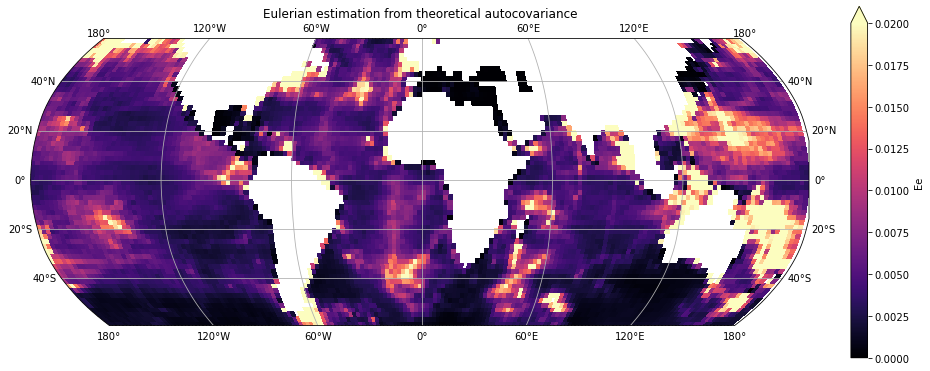

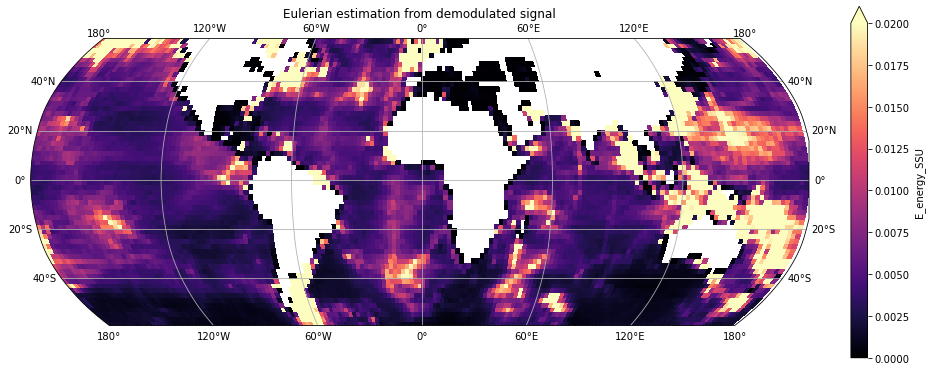

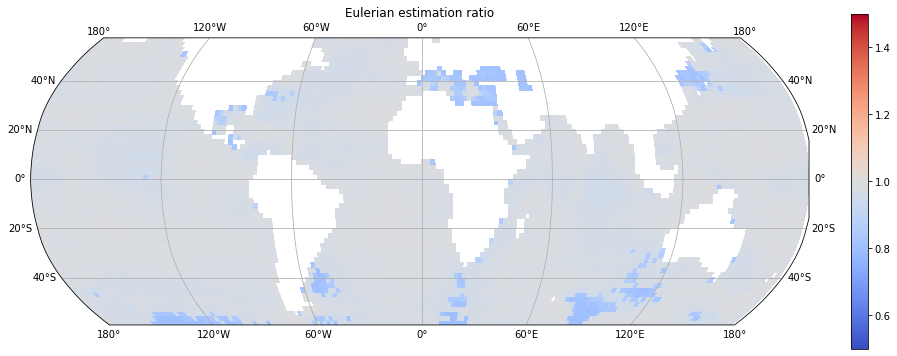

In [20]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.E_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Eulerian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0.5,1.5))
ax.set_title('Eulerian estimation ratio')

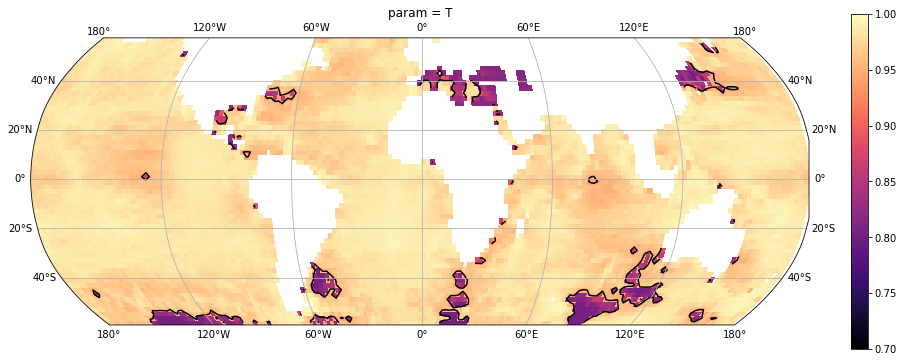

In [21]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.Ee/hf_dl2.E_energy_SSU,colmap='magma',vlim=(0.7,1.))
ax.set_title('Eulerian estimation ratio')
dsE.sel(param='T').parameters_SSU.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

Text(0.5, 1.0, 'Lagrangian estimation ratio')

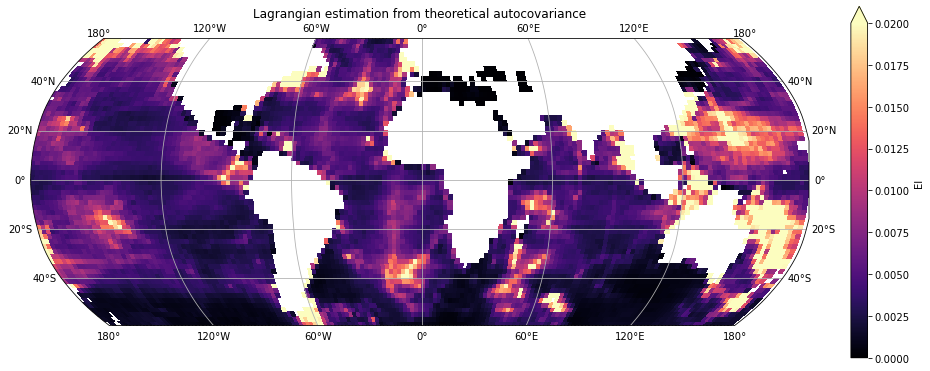

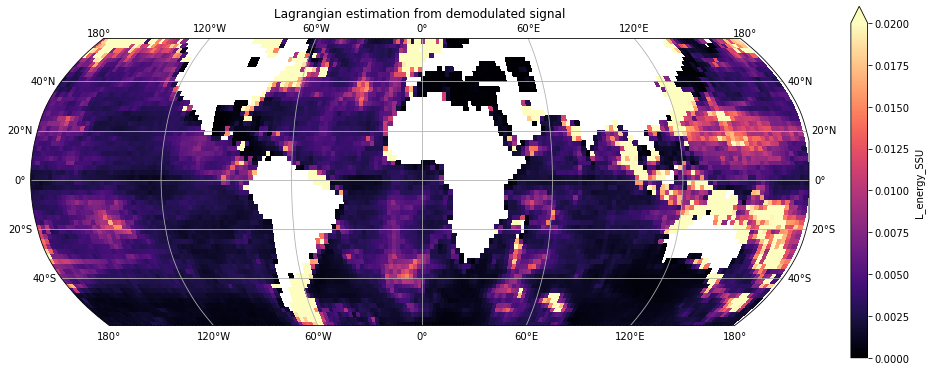

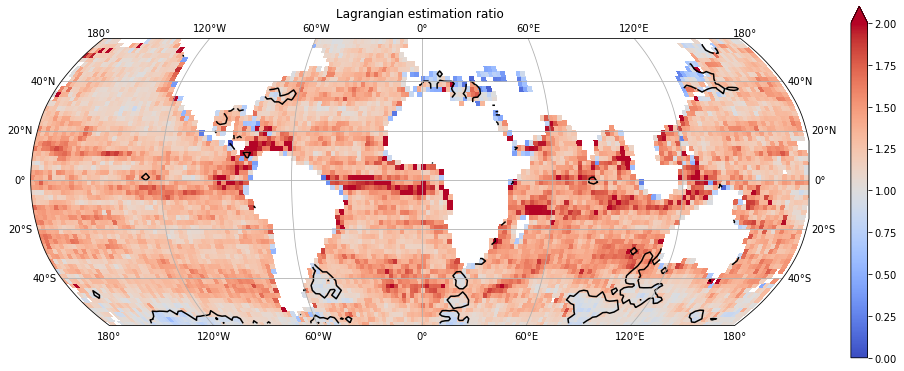

In [22]:
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from theoretical autocovariance')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(hf_dl2.L_energy_SSU,colmap='magma',vlim=(0,0.02))
ax.set_title('Lagrangian estimation from demodulated signal')
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps(ds_predict.El/hf_dl2.L_energy_SSU,colmap='coolwarm',vlim=(0,2))
dsE.sel(param='T').parameters_SSU.plot.contour(levels=[10],ax=ax,colors='k',
                                               transform=ccrs.PlateCarree(),y='lat_bins')

ax.set_title('Lagrangian estimation ratio')

In [23]:
hf_dl2 = hf_dl2.where(hf_dl2.waterdepth>500)

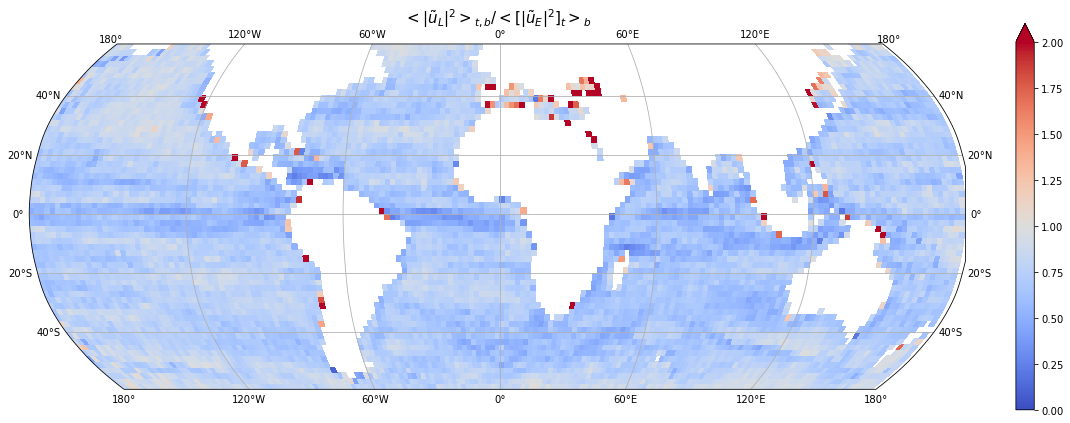

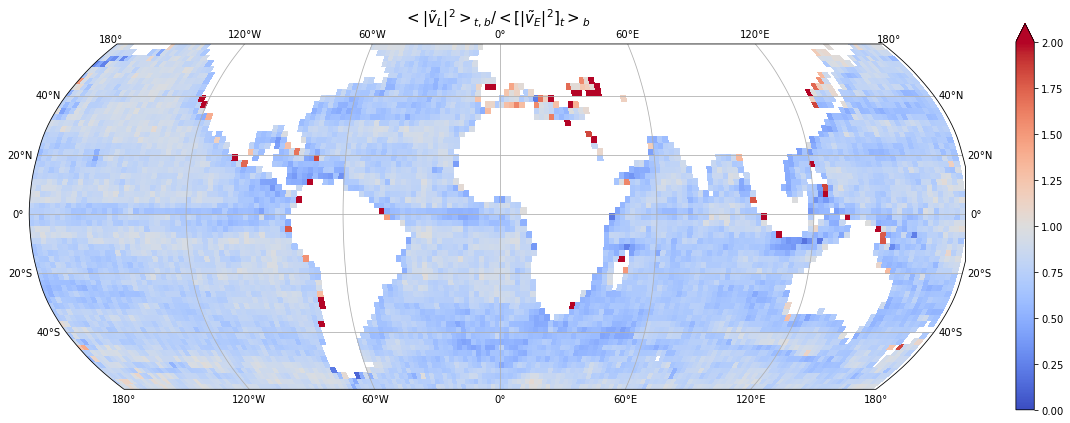

In [25]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSU/hf_dl2.E_energy_SSU,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$<\vert\tilde{u}_L\vert^2>_{t,b}/<[\vert\tilde{u}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(hf_dl2.L_energy_SSV/hf_dl2.E_energy_SSV,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$<\vert\tilde{v}_L\vert^2>_{t,b}/<[\vert\tilde{v}_E\vert^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/ratio_SSV.png',bbox_inches='tight')

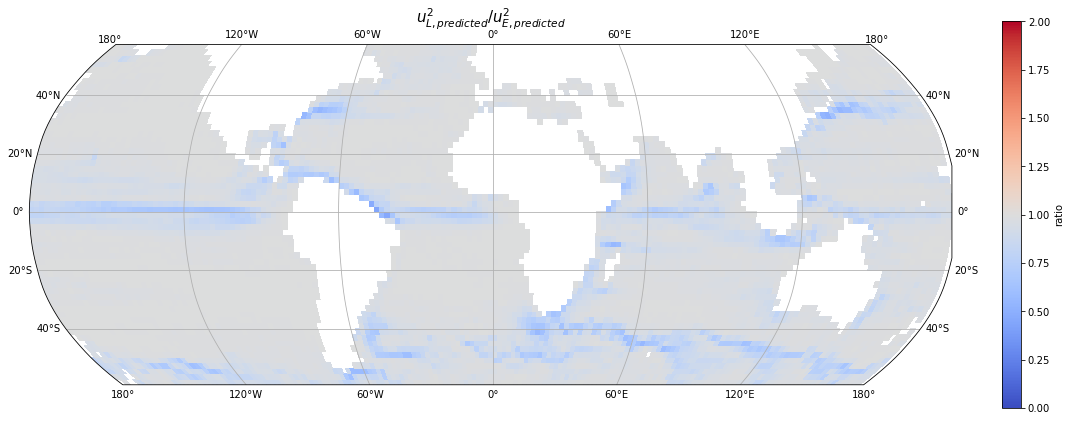

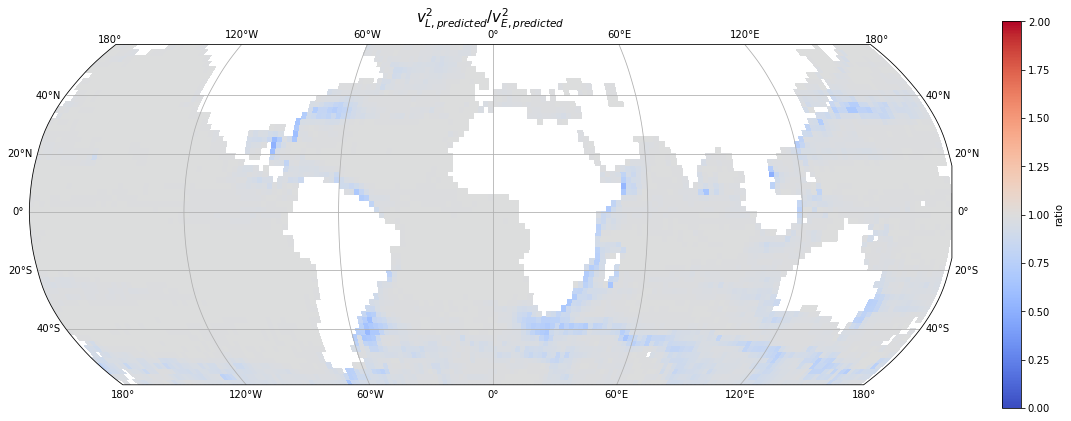

In [26]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_predict.ratio,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$u_{L,predicted}^2/u_{E,predicted}^2$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_SSU.png',bbox_inches='tight')
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(dsV_predict.ratio,colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$v_{L,predicted}^2/v_{E,predicted}^2$',size=15)
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/predicted_ratio_SSV.png',bbox_inches='tight')

In [18]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
L = np.arange(1e3,1000e3,10e3)
k = 2*np.pi/L # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=k, Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10,'k':-1})
dsV = xr.Dataset(dict(T=(["lon",'lat'],TeV), k=k, Ubar=(["lon",'lat'], np.sqrt(Vlbar)),
                     Tbar=(["lon",'lat'], TlbarV.T), U=(["lon",'lat'], V)))
dsV = dsV.chunk({"lon":10,'lat':10,'k':-1})
ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59, k: 100)
Coordinates:
  * k        (k) float64 0.006283 0.0005712 0.0002992 ... 6.405e-06 6.34e-06
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [19]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)
T = np.nanmean(TeV) # days
Ee_V,El_V,ratio_V = get_lagrangian_energy_loss(omega, bandwidth, dsV, U=dsV.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


In [20]:
El = El.compute()
Ee = Ee.compute()
ratio = El/Ee

In [21]:
El_V = El_V.compute()
Ee_V = Ee_V.compute()
ratio_V = El_V/Ee_V

In [22]:
ds_predict = xr.Dataset({'Ee':Ee,'El':El,'ratio':ratio})
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

ds_predict = ds_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
ds_predict = ds_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})
ds_predict

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, k: 100)
Coordinates:
    T         (lon_bins, lat_bins) float64 17.33 19.92 18.8 ... 46.49 28.4 46.25
    Ubar      (lon_bins, lat_bins) float64 0.1195 0.2037 ... 0.1299 0.1297
    Tbar      (lon_bins, lat_bins) float64 nan 4.135 3.261 ... 2.209 1.659 1.498
  * k         (k) float64 0.006283 0.0005712 0.0002992 ... 6.405e-06 6.34e-06
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
Data variables:
    Ee        (lon_bins, lat_bins) float64 0.001601 0.001412 ... 0.02003 0.019
    El        (lon_bins, lat_bins, k) float64 nan nan nan ... 0.01899 0.01899
    ratio     (lon_bins, lat_bins, k) float64 nan nan nan ... 0.9997 0.9997

In [23]:
dsV_predict = xr.Dataset({'Ee':Ee_V,'El':El_V,'ratio':ratio_V})#,compat='override')
#ds_predict_SSV = xr.Dataset({'Ee':Ee_SSV,'El':El_SSV,'ratio':ratio_SSV})

dsV_predict = dsV_predict.rename({'lon':'lon_bins','lat':'lat_bins'})
dsV_predict = dsV_predict.assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [24]:
El_true = hf_dl2.L_energy_SSU
ElV_true = hf_dl2.L_energy_SSV

In [25]:
id_min = np.abs(ds_predict.El-El_true).idxmin('k',skipna=False)
id_minV = np.abs(dsV_predict.El-ElV_true).idxmin('k',skipna=False)
#ds_predict.k#.isel(k=np.abs(ds_predict.El-El_true).argmin('k',skipna=False).values)
#.plot(y='lat_bins')

In [36]:
id_minV.to_netcdf('/home1/datawork/zcaspar/mit4320/k_estimateV.nc')

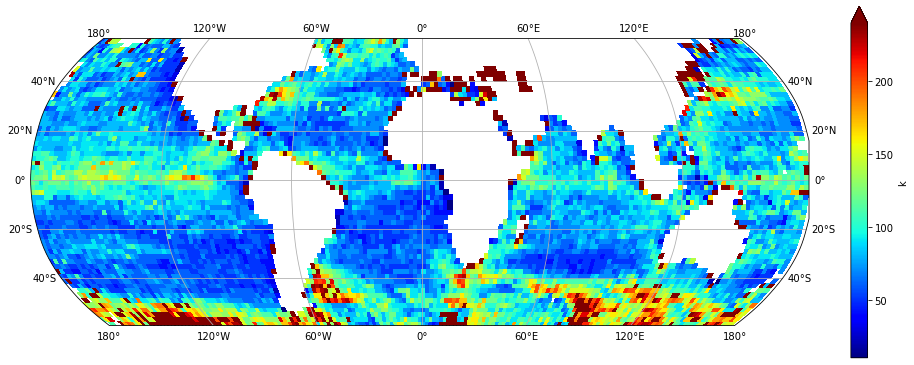

In [27]:
#.plot(y='lat_bins')
id_min = id_min.where(2*np.pi/id_min*1e-3>1)
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_min*1e-3),colmap='jet',vlim=(10,240))

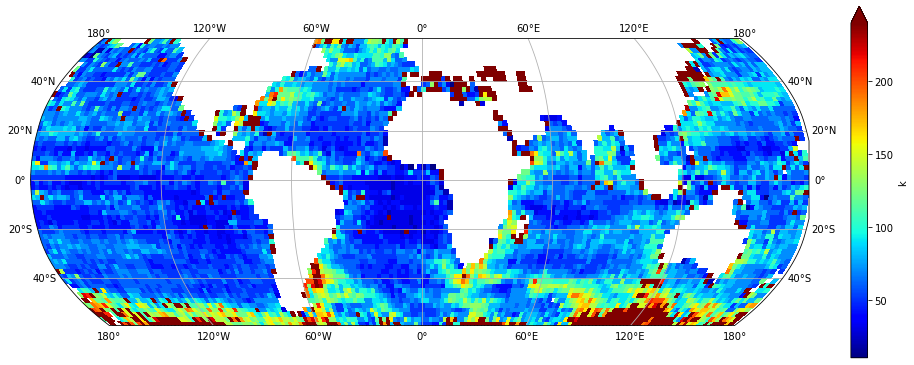

In [28]:
id_minV = id_minV.where(2*np.pi/id_minV*1e-3>1)
fig = plt.figure(figsize=(15,15))
fig,ax = plot_maps((2*np.pi/id_minV*1e-3),colmap='jet',vlim=(10,240))

In [29]:
# wave
omega = (omega_S2+omega_M2)/2 # cpd
T = np.nanmean(Te) # days
k = id_min # rad/m


# filter
bandwidth = 0.4 # cpd
ds = xr.Dataset(dict(T=(["lon",'lat'],Te), k=(["lon",'lat'],k.values), Ubar=(["lon",'lat'], np.sqrt(Ulbar)),
                     Tbar=(["lon",'lat'], Tlbar.T), U=(["lon",'lat'], U)))
ds = ds.chunk({"lon":10,'lat':10})


ds

<xarray.Dataset>
Dimensions:  (lon: 179, lat: 59)
Dimensions without coordinates: lon, lat
Data variables:
    T        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    k        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Ubar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    Tbar     (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    U        (lon, lat) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

In [30]:
Ee,El,ratio = get_lagrangian_energy_loss(omega, bandwidth, ds, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']


In [31]:
El = El.compute()

El = El.rename({'lon':'lon_bins','lat':'lat_bins'}
              ).assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

In [32]:
Ee = Ee.compute()

Ee = Ee.rename({'lon':'lon_bins','lat':'lat_bins'}
              ).assign_coords({'lon_bins':dsE.lon_bins,'lat_bins':dsE.lat_bins})

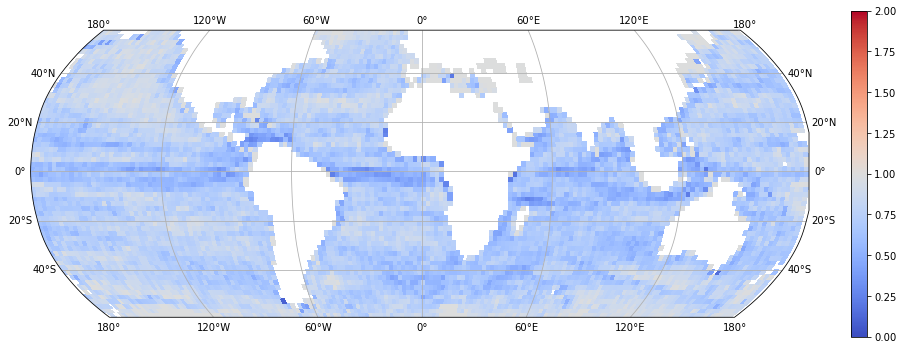

In [34]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(El/Ee,colmap='coolwarm',vlim=(0,2))

##### Zoom Gulf stream

In [138]:
lat0,lat1 = 34,44
lon0,lon1 = -78,-66

In [156]:
dsi_hf = hf_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf = low_dl2.sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

dsi_hf_out = xr.merge([dsE_out.parameters,dsL_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))
dsi_lf_out = xr.merge([dsE_low_out.parameters,dsL_low_out.parameters.rename('L_parameters')]
                     ).sel(lon_bins=slice(lon0,lon1),lat_bins=slice(lat0,lat1))

In [157]:
dsi_hf_out

<xarray.Dataset>
Dimensions:       (lon_bins: 6, lat_bins: 5, param: 2)
Coordinates:
  * lon_bins      (lon_bins) float64 -77.0 -75.0 -73.0 -71.0 -69.0 -67.0
  * lat_bins      (lat_bins) float64 35.0 37.0 39.0 41.0 43.0
  * param         (param) <U1 'T' 'V'
Data variables:
    parameters    (lon_bins, lat_bins, param) float64 nan nan nan ... nan nan
    L_parameters  (lat_bins, lon_bins, param) float64 nan nan 2.5 ... nan nan

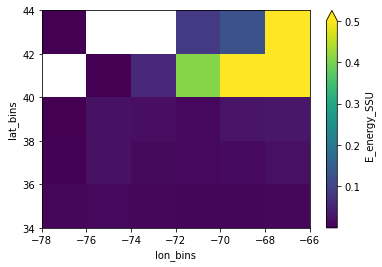

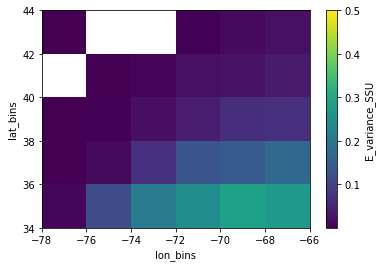

In [149]:
dsi_hf.E_energy_SSU.plot(y='lat_bins',vmax=0.5)
plt.figure()
dsi_lf.E_variance_SSU.plot(y='lat_bins',vmax=0.5)

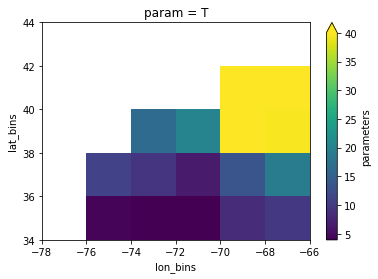

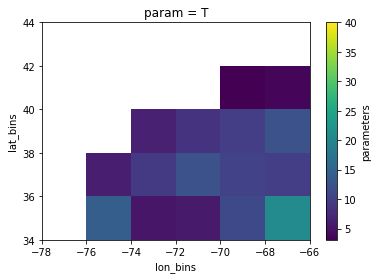

In [162]:
dsi_hf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').parameters.plot(y='lat_bins',vmax=40)

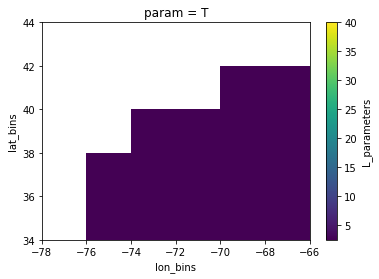

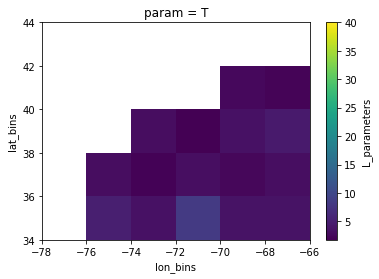

In [163]:
dsi_hf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)
plt.figure()
dsi_lf_out.sel(param='T').L_parameters.plot(y='lat_bins',vmax=40)

In [37]:
cluster.close()